In [ ]:
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

**Reading the train and test csvs**

In [ ]:
train = pd.read_csv('./train.csv')
train

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [ ]:
test = pd.read_csv('./test.csv')
test

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
...,...,...,...,...
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False


**Simple Feature Engineering with preprocessing**

In [ ]:
train['Date'] = pd.to_datetime(train['Date'])

In [ ]:
train['lag1'] = train['Weekly_Sales'].shift(1)
train['lag4'] = train['Weekly_Sales'].shift(4)

In [ ]:
train.shape

(421570, 7)

**EDA**

**No lag**

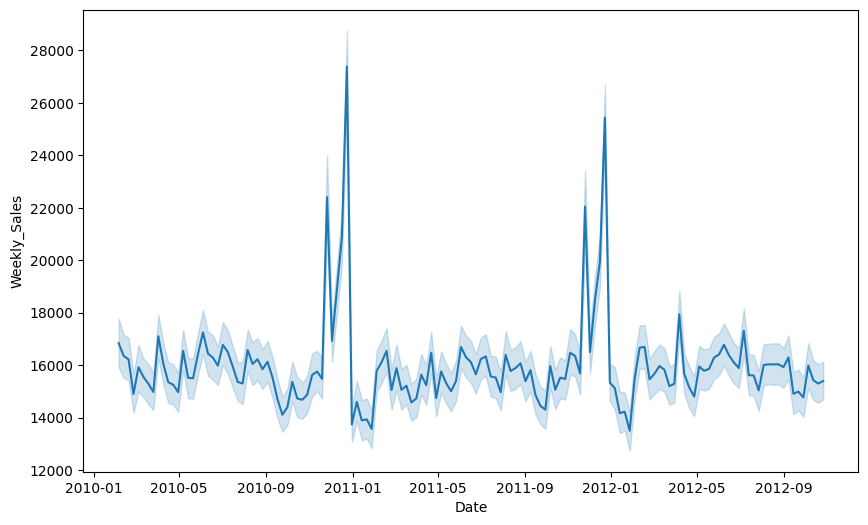

In [ ]:
from seaborn import lineplot
plt.figure(figsize=(10,6))
lineplot(data=train,x=train['Date'],y=train['Weekly_Sales'])
plt.show()

**with 1 week lag**

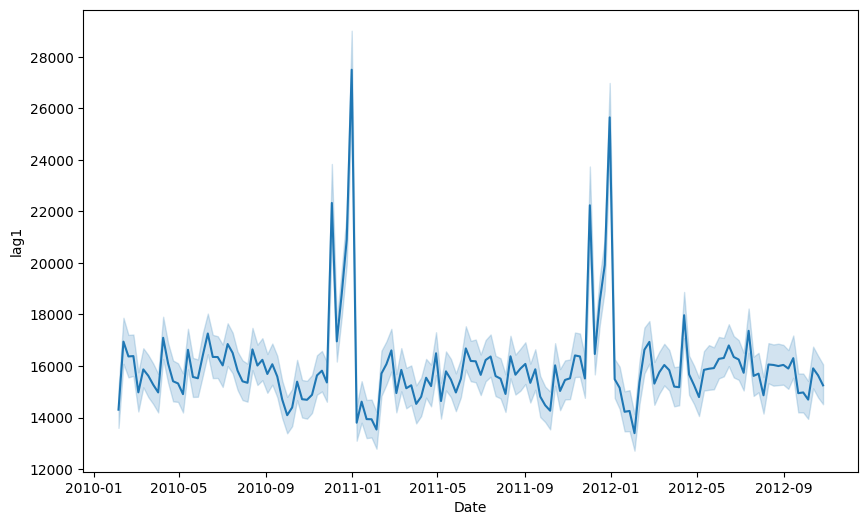

In [ ]:
plt.figure(figsize=(10,6))
lineplot(data=train,x=train['Date'],y=train['lag1'])
plt.show()

<Axes: >

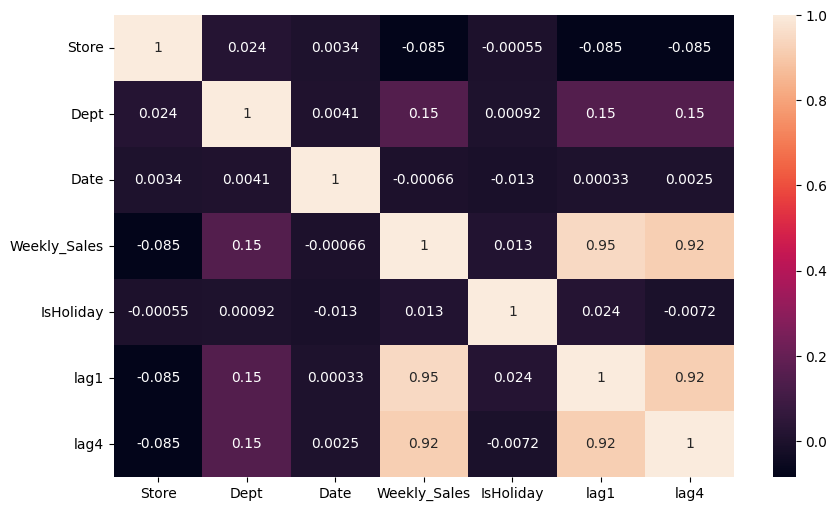

In [ ]:
corr = train.corr()
from seaborn import heatmap
plt.figure(figsize=(10,6))
heatmap(corr,annot=True)

**1 month lag**

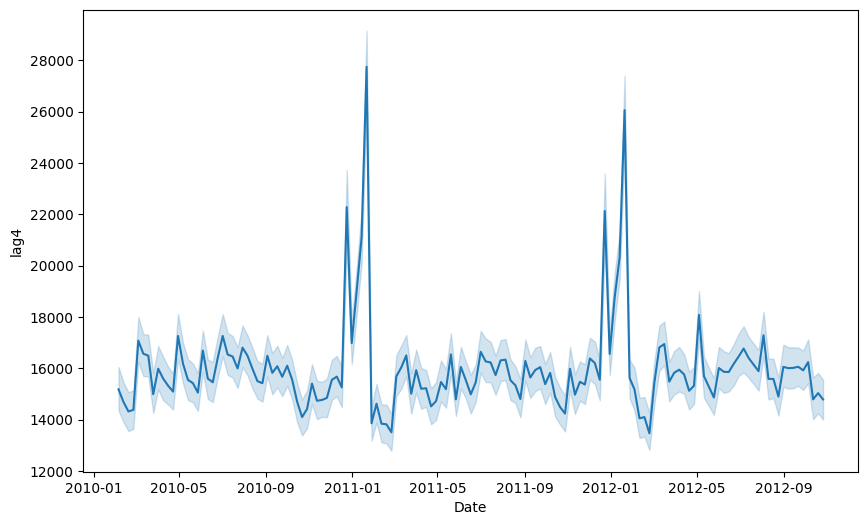

In [ ]:
plt.figure(figsize=(10,6))
lineplot(data=train,x=train['Date'],y=train['lag4'])
plt.show()

**Building the rolling av model**

In [ ]:
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from prophet import Prophet
from prophet.diagnostics import performance_metrics,cross_validation
from sklearn.model_selection import train_test_split

In [ ]:
train

,Store,Dept,Date,Weekly_Sales,IsHoliday,lag1,lag4
0,1,1,2010-02-05,24924.50,False,NaN,NaN
1,1,1,2010-02-12,46039.49,True,24924.50,NaN
2,1,1,2010-02-19,41595.55,False,46039.49,NaN
3,1,1,2010-02-26,19403.54,False,41595.55,NaN
4,1,1,2010-03-05,21827.90,False,19403.54,24924.50
...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,467.30,346.04
421566,45,98,2012-10-05,628.10,False,508.37,352.44
421567,45,98,2012-10-12,1061.02,False,628.10,605.96
421568,45,98,2012-10-19,760.01,False,1061.02,467.30


**Split into train and test**

In [ ]:
train_size=int(len(train)*0.8)
y_train = train[:train_size][['Weekly_Sales','Date']].rename(columns={'Date':'ds',"Weekly_Sales":'y'})
y_test = train[train_size:][['Weekly_Sales','Date']].rename(columns={'Date':'ds',"Weekly_Sales":'y'})

In [ ]:
y_train.shape,y_test.shape

((337256, 2), (84314, 2))

**Hyperparameter tune the model manually**

In [ ]:
lowest_rmse=np.inf
for changepoint_prior_scale in [0.01, 0.05, 0.1, 0.5]:
  for seasonality_prior_scale in [0.01, 0.1, 1.0, 10.0]:
    model = Prophet(weekly_seasonality=True,yearly_seasonality=True,changepoint_prior_scale=changepoint_prior_scale,seasonality_prior_scale=seasonality_prior_scale)
    model.fit(y_train)

    df_cv = cross_validation(
        model,
        initial="730 days",   # how much history for training
        horizon="90 days",    # forecast horizon
        period="180 days"     # step size between folds
    )
    metric = performance_metrics(df_cv, rolling_window=1)['rmse'].values[0]


    if metric < lowest_rmse:
      print(f"Metrics for changepoint_prior_scale={changepoint_prior_scale}, seasonality_prior_scale={seasonality_prior_scale}:")
      print(metric)
      lowest_rmse= metric
      best_cpps = changepoint_prior_scale
      best_sps = seasonality_prior_scale

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/ilieh0ni.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/p_esdwyz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78833', 'data', 'file=/tmp/tmpx0nszisk/ilieh0ni.json', 'init=/tmp/tmpx0nszisk/p_esdwyz.json', 'output', 'file=/tmp/tmpx0nszisk/prophet_modelinj20ajr/prophet_model-20250914164808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:48:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:48:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2012-07-28 00:00:00 and 2012-07-28 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/nkdbbtcm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/89946aoz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93814', 'data', 'file=/tmp/tmpx0nszisk/nkdbbtcm.json', 'init=/tmp/tmpx0nszisk/89946aoz.json', 'output', 'file=/tmp/tmpx0nszisk/prophet_model3y316fz8/prophet_model-20250914164845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:48:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:49:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Metrics for changepoint_prior_scale=0.01, seasonality_prior_scale=0.01:
22503.347813661527


DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/_03qktx8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/dwkx0rml.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60083', 'data', 'file=/tmp/tmpx0nszisk/_03qktx8.json', 'init=/tmp/tmpx0nszisk/dwkx0rml.json', 'output', 'file=/tmp/tmpx0nszisk/prophet_modelnjqgnpj2/prophet_model-20250914164938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:49:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:49:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2012-07-28 00:00:00 and 2012-07-28 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/p6u0_1cp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/umo8b6pu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42256', 'data', 'file=/tmp/tmpx0nszisk/p6u0_1cp.json', 'init=/tmp/tmpx0nszisk/umo8b6pu.json', 'output', 'file=/tmp/tmpx0nszisk/prophet_modeluopjiks9/prophet_model-20250914165014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:50:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:50:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Metrics for changepoint_prior_scale=0.01, seasonality_prior_scale=0.1:
22502.68752018937


DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/3xhkrl_o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/3ywx9oho.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85812', 'data', 'file=/tmp/tmpx0nszisk/3xhkrl_o.json', 'init=/tmp/tmpx0nszisk/3ywx9oho.json', 'output', 'file=/tmp/tmpx0nszisk/prophet_model0od3vway/prophet_model-20250914165102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:51:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:51:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2012-07-28 00:00:00 and 2012-07-28 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/8slakwtg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/e4j_h1sh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16898', 'data', 'file=/tmp/tmpx0nszisk/8slakwtg.json', 'init=/tmp/tmpx0nszisk/e4j_h1sh.json', 'output', 'file=/tmp/tmpx0nszisk/prophet_modelsrlmeby6/prophet_model-20250914165135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:51:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:51:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/7bj7rz9c.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/u7m166b1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/ctjw5czn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74406', 'data', 'file=/tmp/tmpx0nszisk/u7m166b1.json', 'init=/tmp/tmpx0nszisk/ctjw5czn.json', 'output', 'file=/tmp/tmpx0nszisk/prophet_modelxm1q6_pr/prophet_model-20250914165306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:53:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:53:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Metrics for changepoint_prior_scale=0.01, seasonality_prior_scale=10.0:
22502.55960836008


DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/hj8ed7m4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/ipeldqtu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40263', 'data', 'file=/tmp/tmpx0nszisk/hj8ed7m4.json', 'init=/tmp/tmpx0nszisk/ipeldqtu.json', 'output', 'file=/tmp/tmpx0nszisk/prophet_modelr03oa6ma/prophet_model-20250914165400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:54:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:54:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2012-07-28 00:00:00 and 2012-07-28 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/qw6j06ug.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/megbfd43.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65534', 'data', 'file=/tmp/tmpx0nszisk/qw6j06ug.json', 'init=/tmp/tmpx0nszisk/megbfd43.json', 'output', 'file=/tmp/tmpx0nszisk/prophet_modeljmnl0um2/prophet_model-20250914165435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:54:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:54:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/2fwzya80.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/73ph3ez7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/byn5tl6w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24173', 'data', 'file=/tmp/tmpx0nszisk/73ph3ez7.json', 'init=/tmp/tmpx0nszisk/byn5tl6w.json', 'output', 'file=/tmp/tmpx0nszisk/prophet_model7lb8ediy/prophet_model-20250914165616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:56:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:56:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/az_58dzc.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/o9zyxp9k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/_bjpelji.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24143', 'data', 'file=/tmp/tmpx0nszisk/o9zyxp9k.json', 'init=/tmp/tmpx0nszisk/_bjpelji.json', 'output', 'file=/tmp/tmpx0nszisk/prophet_modely9d61e3a/prophet_model-20250914165753.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:57:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:58:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/pnn2gjji.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/nbl1rxzv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/6u41hiq_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79168', 'data', 'file=/tmp/tmpx0nszisk/nbl1rxzv.json', 'init=/tmp/tmpx0nszisk/6u41hiq_.json', 'output', 'file=/tmp/tmpx0nszisk/prophet_modelujltl4wm/prophet_model-20250914165924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:59:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:59:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/11v2kg4i.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/7cx7waui.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/3z41q14f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32720', 'data', 'file=/tmp/tmpx0nszisk/7cx7waui.json', 'init=/tmp/tmpx0nszisk/3z41q14f.json', 'output', 'file=/tmp/tmpx0nszisk/prophet_modelfulg0ezk/prophet_model-20250914170054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:00:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:01:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/vvb0z0l9.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/p94c46u_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/q_cnhvzz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96356', 'data', 'file=/tmp/tmpx0nszisk/p94c46u_.json', 'init=/tmp/tmpx0nszisk/q_cnhvzz.json', 'output', 'file=/tmp/tmpx0nszisk/prophet_modelbplnqanb/prophet_model-20250914170224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:02:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:02:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/4w3m5s_p.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/tjmc33ad.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/1ujes90b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39440', 'data', 'file=/tmp/tmpx0nszisk/tjmc33ad.json', 'init=/tmp/tmpx0nszisk/1ujes90b.json', 'output', 'file=/tmp/tmpx0nszisk/prophet_modelo01o8ayv/prophet_model-20250914170410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:04:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/f6b0p9mw.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/m0vwuhjh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/tdvyi0zo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96659', 'data', 'file=/tmp/tmpx0nszisk/m0vwuhjh.json', 'init=/tmp/tmpx0nszisk/tdvyi0zo.json', 'output', 'file=/tmp/tmpx0nszisk/prophet_modelwnbmty0n/prophet_model-20250914170602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/cwrt7f1z.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/iy2adjod.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/2pohkg9j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81143', 'data', 'file=/tmp/tmpx0nszisk/iy2adjod.json', 'init=/tmp/tmpx0nszisk/2pohkg9j.json', 'output', 'file=/tmp/tmpx0nszisk/prophet_model9_qjlvrh/prophet_model-20250914170746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:08:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/3uxlct_k.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/y3ilv2lt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/31d0we8d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91608', 'data', 'file=/tmp/tmpx0nszisk/y3ilv2lt.json', 'init=/tmp/tmpx0nszisk/31d0we8d.json', 'output', 'file=/tmp/tmpx0nszisk/prophet_modelbhjab42m/prophet_model-20250914170910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/06up2qol.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/pb1_wowq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/n0jx2y57.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58187', 'data', 'file=/tmp/tmpx0nszisk/pb1_wowq.json', 'init=/tmp/tmpx0nszisk/n0jx2y57.json', 'output', 'file=/tmp/tmpx0nszisk/prophet_model0mx_3zbm/prophet_model-20250914171039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/tmdy7_qp.json
DEBUG:cmdstanpy:input tempfile:

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/6a7csi_l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/fg1xwwkb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19196', 'data', 'file=/tmp/tmpx0nszisk/6a7csi_l.json', 'init=/tmp/tmpx0nszisk/fg1xwwkb.json', 'output', 'file=/tmp/tmpx0nszisk/prophet_modelyohgjtqf/prophet_model-20250914171211.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Skipping MAPE because y close to 0


**Best Parameters with Scores**

In [ ]:
print(f"the lowest rmse is at {lowest_rmse} with changepoint_prior_scale = {best_cpps} and seasonality_prior scale = {best_sps}")

the lowest rmse is at 22502.55960836008 with changepoint_prior_scale = 0.01 and seasonality_prior scale = 10.0


**Build best model**

In [ ]:
model  = Prophet(weekly_seasonality=True,yearly_seasonality=True,changepoint_prior_scale=best_cpps,seasonality_prior_scale=best_sps)
model.fit(y_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/sryw7vyh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx0nszisk/33psajz2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81156', 'data', 'file=/tmp/tmpx0nszisk/sryw7vyh.json', 'init=/tmp/tmpx0nszisk/33psajz2.json', 'output', 'file=/tmp/tmpx0nszisk/prophet_modelm6qjz97w/prophet_model-20250914172209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:22:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:22:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=52, freq="W")
forecast = model.predict(future)

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-02-05,22928.073378,-11526.922739,46644.137779,22928.073378,22928.073378,-5737.444038,-5737.444038,-5737.444038,-5989.266051,-5989.266051,-5989.266051,251.822013,251.822013,251.822013,0.0,0.0,0.0,17190.629341
1,2010-02-12,22939.020834,-13137.076560,47902.584198,22939.020834,22939.020834,-5503.286431,-5503.286431,-5503.286431,-5989.266051,-5989.266051,-5989.266051,485.979620,485.979620,485.979620,0.0,0.0,0.0,17435.734403
2,2010-02-19,22949.968290,-14972.499816,46358.899321,22949.968290,22949.968290,-6029.938435,-6029.938435,-6029.938435,-5989.266051,-5989.266051,-5989.266051,-40.672384,-40.672384,-40.672384,0.0,0.0,0.0,16920.029855
3,2010-02-26,22960.915745,-12491.159944,47742.655125,22960.915745,22960.915745,-6486.809303,-6486.809303,-6486.809303,-5989.266051,-5989.266051,-5989.266051,-497.543252,-497.543252,-497.543252,0.0,0.0,0.0,16474.106442
4,2010-03-05,22971.863201,-13757.943423,46190.572953,22971.863201,22971.863201,-6584.286698,-6584.286698,-6584.286698,-5989.266051,-5989.266051,-5989.266051,-595.020647,-595.020647,-595.020647,0.0,0.0,0.0,16387.576503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,2013-09-22,23250.883799,-6220.611836,52645.590252,23017.668416,23481.493640,-722.472988,-722.472988,-722.472988,998.214226,998.214226,998.214226,-1720.687214,-1720.687214,-1720.687214,0.0,0.0,0.0,22528.410811
191,2013-09-29,23254.500108,-6226.765889,52062.810880,23015.046452,23490.289951,-392.328440,-392.328440,-392.328440,998.214226,998.214226,998.214226,-1390.542666,-1390.542666,-1390.542666,0.0,0.0,0.0,22862.171668
192,2013-10-06,23258.116417,-3624.818911,53280.041928,23012.356823,23501.011090,75.692617,75.692617,75.692617,998.214226,998.214226,998.214226,-922.521609,-922.521609,-922.521609,0.0,0.0,0.0,23333.809034
193,2013-10-13,23261.732726,-8523.275712,54248.942964,23008.346714,23510.915833,137.935274,137.935274,137.935274,998.214226,998.214226,998.214226,-860.278951,-860.278951,-860.278951,0.0,0.0,0.0,23399.668000


**Actual vs Predicted Plot**

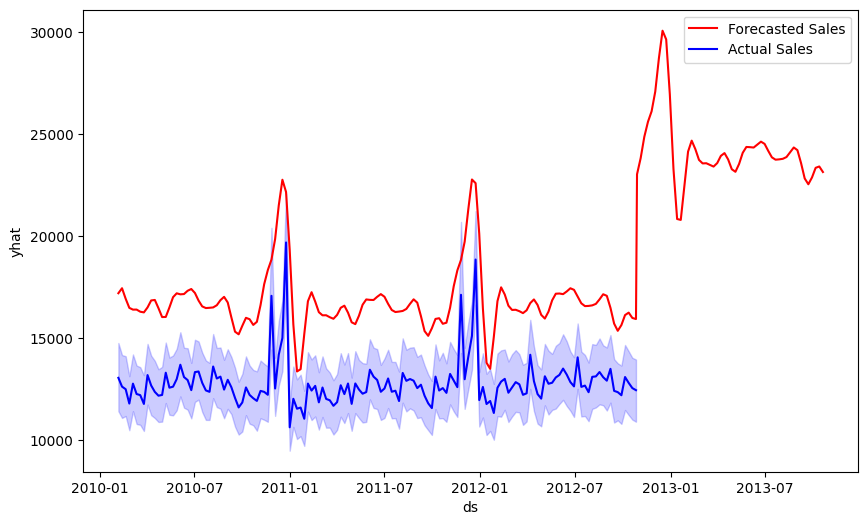

In [ ]:
from seaborn import lineplot
plt.figure(figsize=(10,6))
lineplot(data=forecast,x='ds',y='yhat',color='red', label='Forecasted Sales')
lineplot(data=y_test,x='ds',y='y',color='blue', label='Actual Sales')
plt.legend()
plt.show()